# Bayesian Inference with information content model check for Langevin Equations

We will analyse single particle tracking data for a certain model of Langevin Equations. Now we want to see and verify how well the model fits the data.

## Description of the Model

The Model is described below.

The langevin equation is given by 

$$ \boxed{\frac{d\hat{x}(t)}{dt} = \mu(\hat{x}) f + k_BT\frac{\partial\mu(\hat{x})}{\partial t} + \sqrt{2Dk_BT\mu(\hat{x})}\hat{\xi}(t)} $$

where $$ \boxed{\mu(\hat{x}) = D_0 |\hat{x}|^\alpha} $$

The corresponding Euler-Maruyuma Equation is given as

$$ \boxed{x(t+dt) = x(t) +D_0  |x(t)|^\alpha dt + k_B T \left(\alpha D_0 |x(t)|^{\alpha -1} \dfrac{x(t)}{|x(t)|}\right) dt+\sqrt{2D_0 k_B T |x(t)|^\alpha dt}\hat{N}(t)} $$

where $$ \hat{N}(t) \sim Normal (0,1) $$

## Generating Datasets

We will be working on artificial datasets on which we will be performing Bayesian Inference to get the parameters which we do not know.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from numba import jit

In [2]:
# from the mu equation
D_0 = 0.2

# the initial starting point for the stochastic process
x_0 = 50

# MU = 0.1

#starting time for the process siumulation
t_0 = 0

#ending time for the process simulation
t_e = 100

#The alpha value in the mu equation
ALPHA_M = 1

# the value of f in the models given f=0(Free Model), and f=-0.3(pull Model) 
F_L = [0., -.3]

# the inverse of thermodynamic Beta set as k_BT = 1 for the paper.
k_BT =1

# no of steps
n = 100

# time step dt
DT = (t_e - t_0)/n

VAR_MN = [0, 0.5, 40]

In [3]:
@jit
def Model(num,t_end,F,D,ALPHA):
    y = np.zeros(num)
    y[0] = x_0
    DT = (t_end-t_0)/num
    t = np.arange(t_0, t_end ,DT)
    for i in range(0,num-1):
        y[i+1] = y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1)
        # The github code has values rounded to 3 values after the point
        # y[i+1] = np.round(y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1),3)
    return t, y 

In [4]:
@jit
def Model2(num,t_end,F,D,ALPHA):
    y = np.zeros(num)
    y[0] = x_0
    DT = (t_end-t_0)/num
    t = np.arange(t_0, t_end ,DT)
    for i in range(0,num-1):
        y[i+1] = y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA)) * np.random.normal(0,DT)
        # The github code has values rounded to 3 values after the point
        # y[i+1] = np.round(y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1),3)
    return t, y 

### $M_{clean}$ Model generation

These models do not take into account the measurement noise due to the instrument doing the collecting the SPT data.

#### $M_{clean, free}$ Model

Clean model with $f=0$

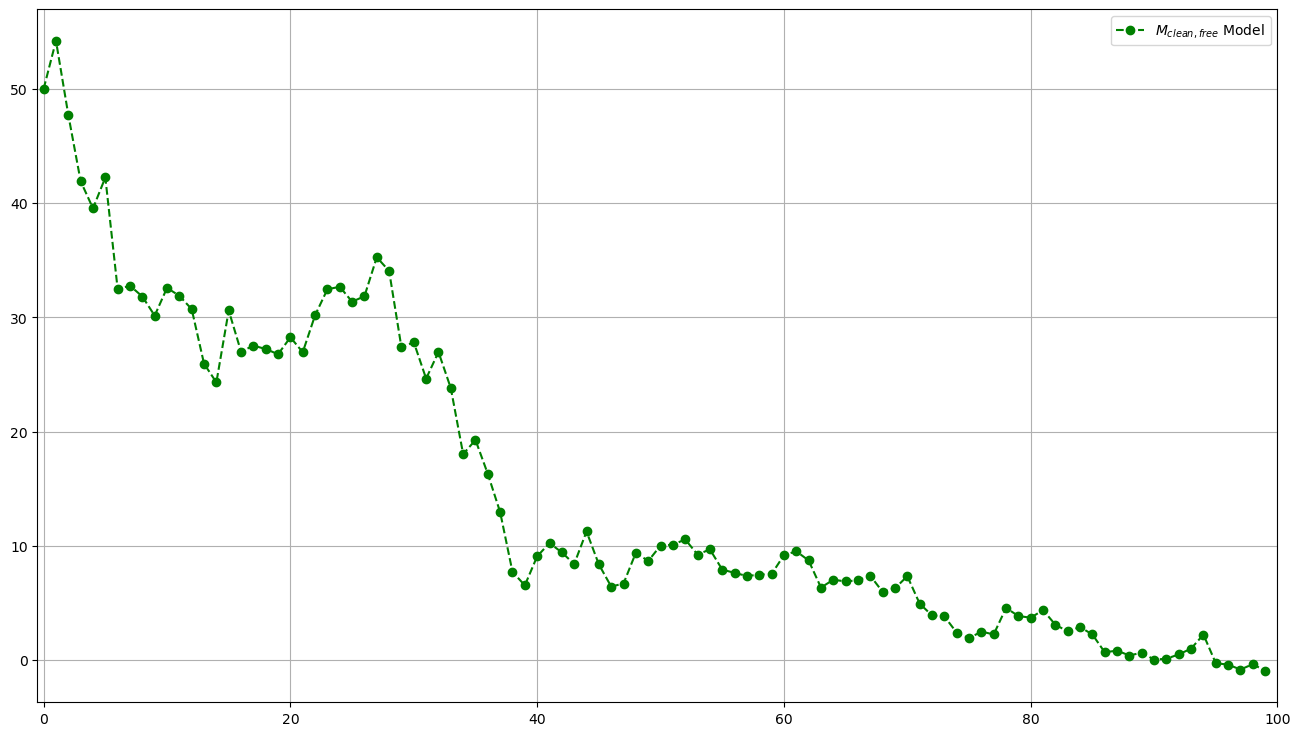

In [5]:
t_clean_free,x_clean_free = Model(n,t_e,F_L[0],D_0,ALPHA_M)

fig,axes = plt.subplots(1,1,figsize=(16,9))
axes.plot(t_clean_free,x_clean_free,'o--g',label = r"$M_{clean, free}$ Model")
axes.set_xlim((-0.5,100))
axes.legend()
axes.grid()

#### $M_{pull, free}$ Model

Clean model with $f=-0.3$

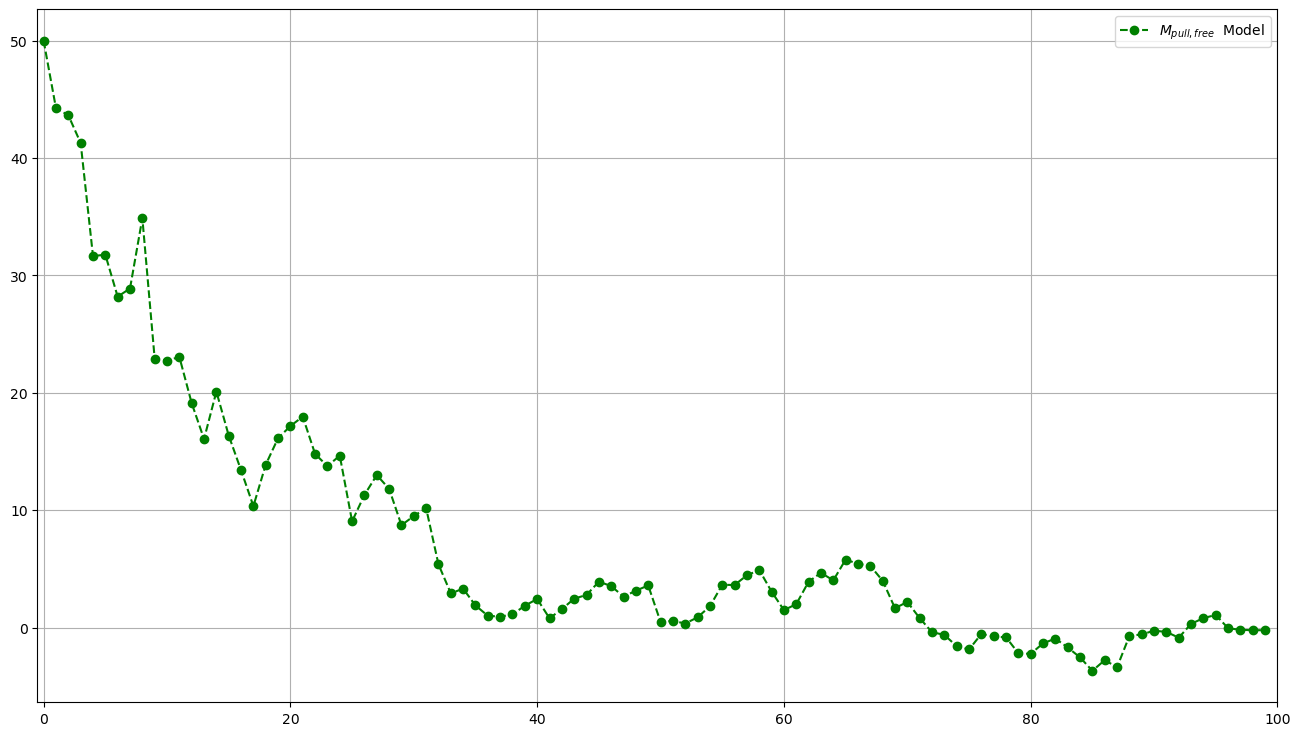

In [6]:
t_pull_free,x_pull_free = Model(n,t_e, F_L[1],D_0,ALPHA_M)
fig,axes = plt.subplots(1,1,figsize=(16,9))
axes.plot(t_pull_free,x_pull_free,'o--g',label = r"$M_{pull, free}$  Model")
axes.set_xlim((-0.5,100))
axes.legend()
axes.grid()   

### Measurement noise

In [7]:
@jit
def NoisyModel(num,t_end,F,D,ALPHA, VARN):
    y = np.zeros(num)
    ytrue = np.zeros(num)
    y[0] = x_0
    ytrue[0] = x_0
    DT = (t_end-t_0)/num
    t = np.arange(t_0, t_end ,DT)
    for i in range(0,num-1):
        ytrue[i+1] = ytrue[i] + D * (np.abs(ytrue[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(ytrue[i])**(ALPHA-1)*(ytrue[i]/(np.abs(ytrue[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(ytrue[i])**ALPHA) *  DT) * np.random.normal(0,1)
        y[i+1] = ytrue[i+1] + np.random.normal(0,np.sqrt(VARN))
    return t, y, ytrue

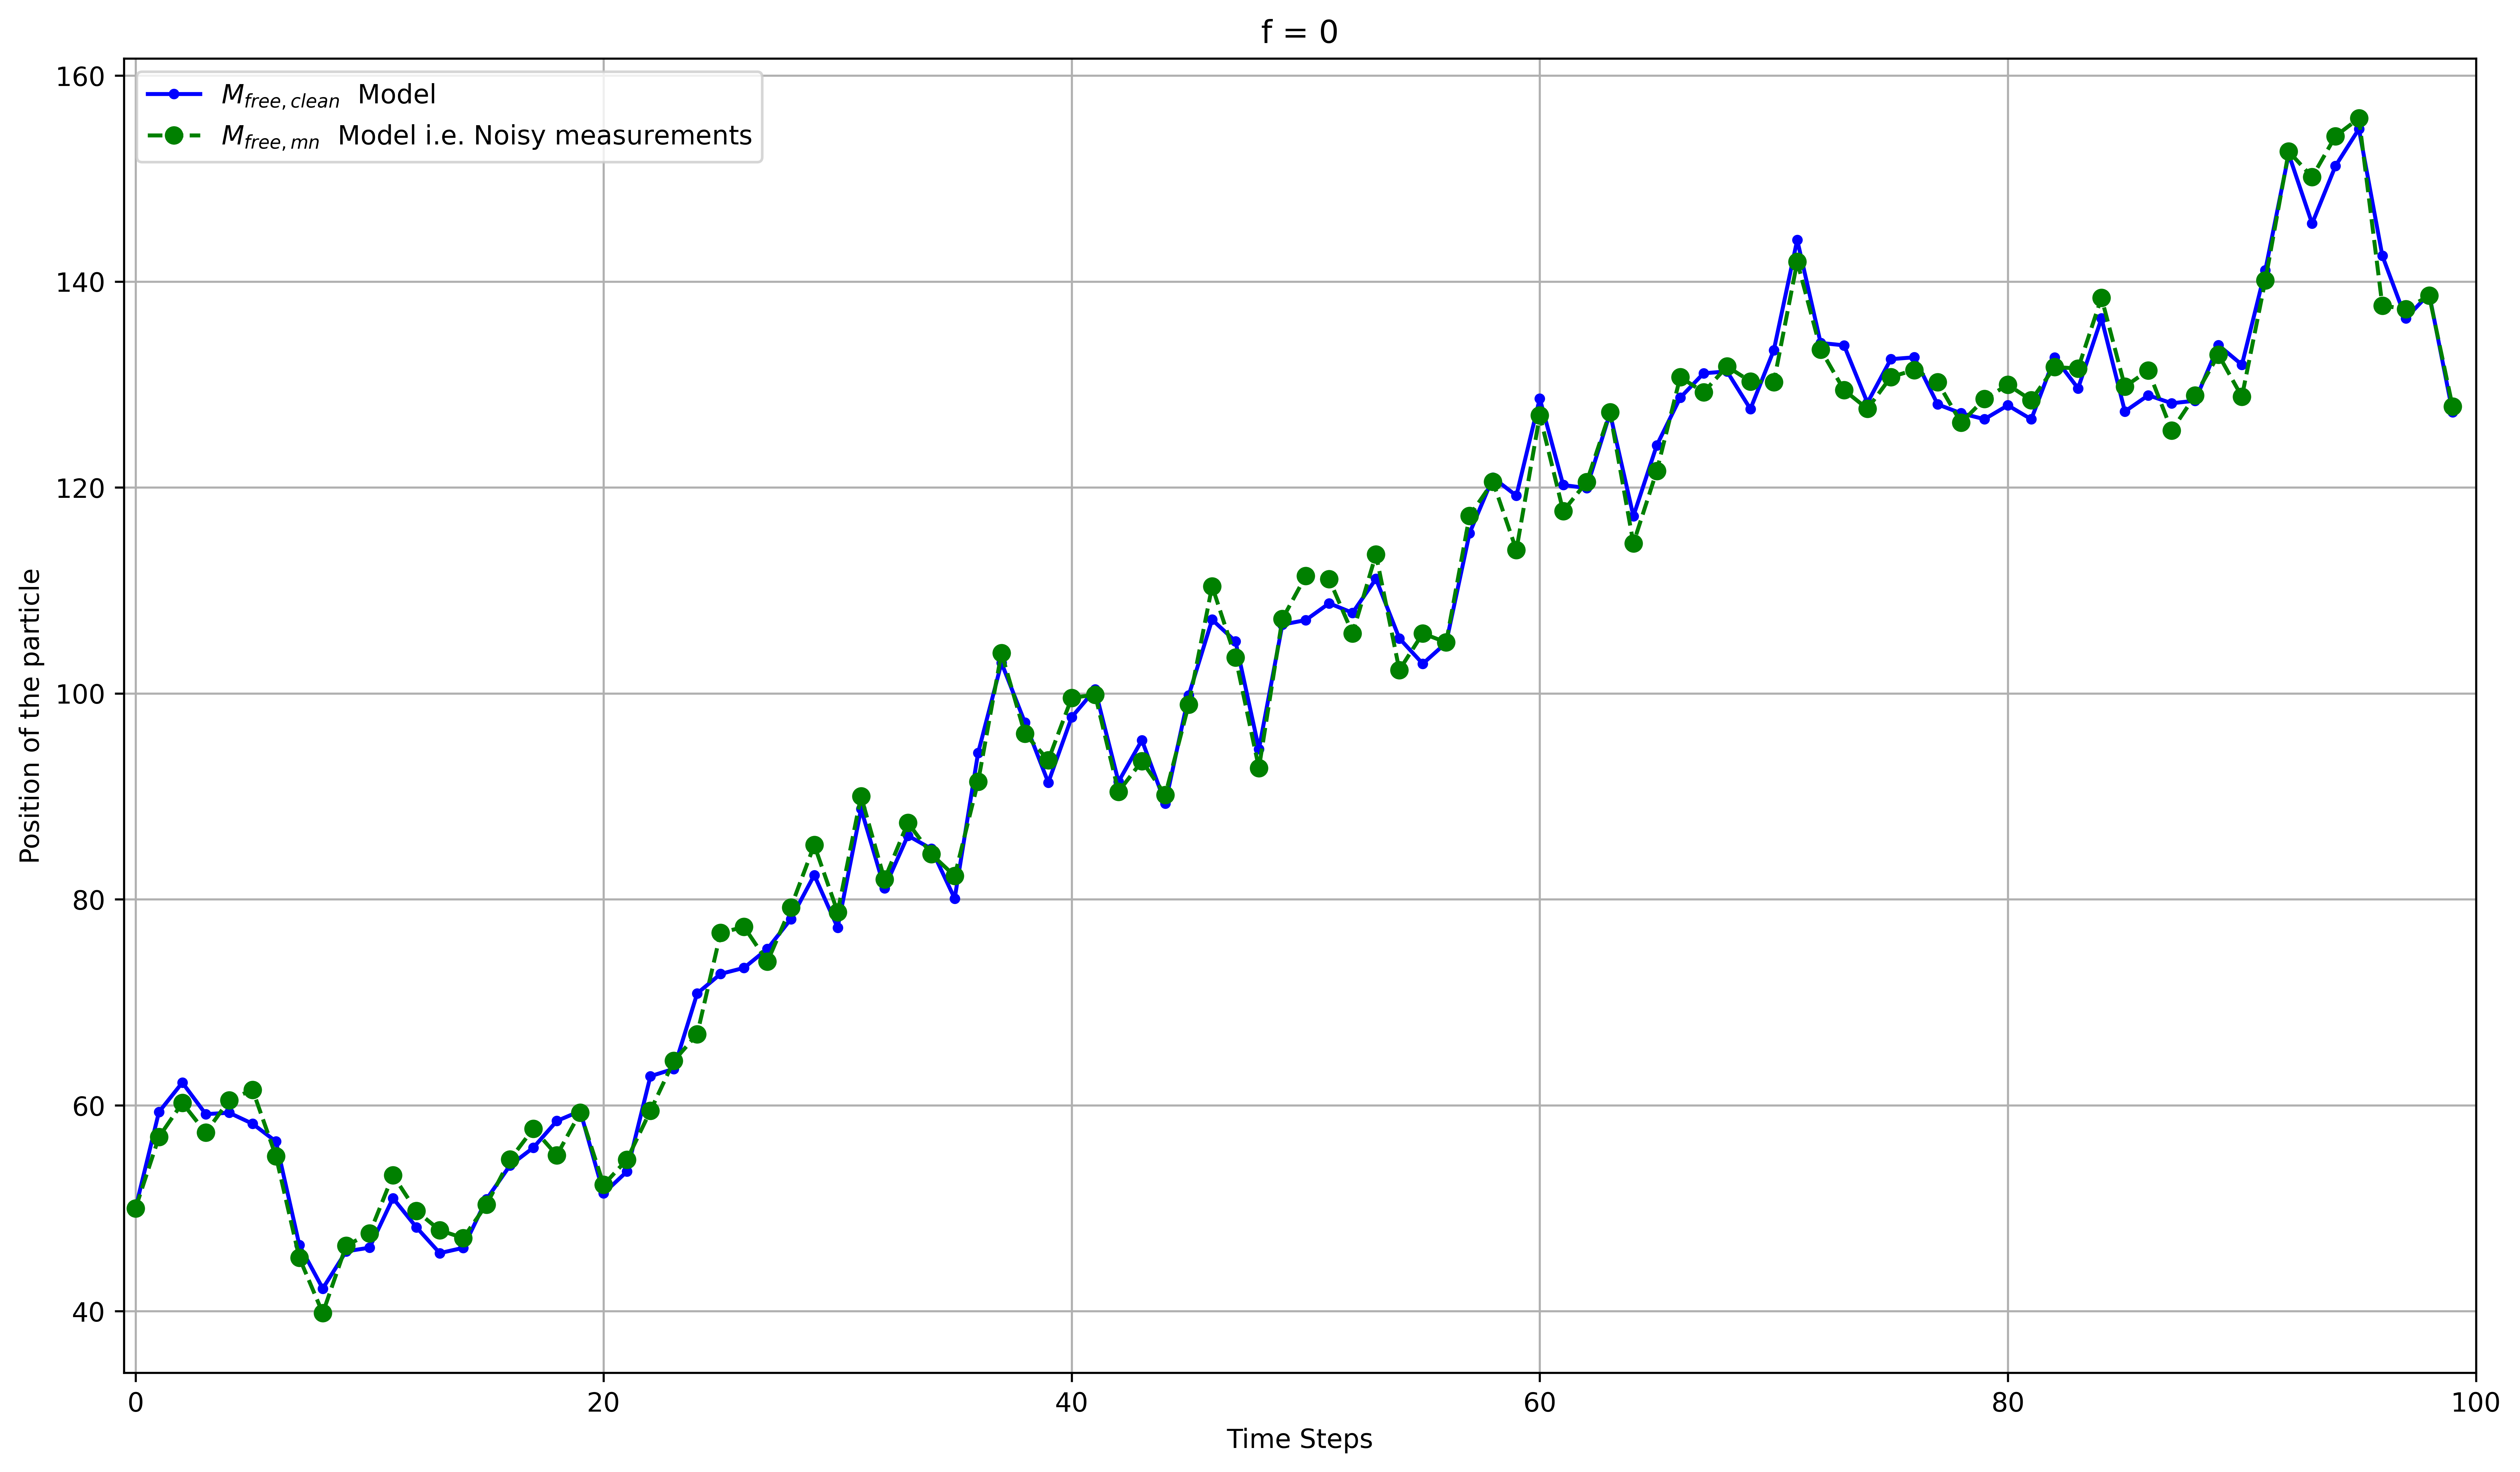

In [8]:
n=100
t_clean_mn, x_free_mn, x_clean_free = NoisyModel(n,t_e, F_L[0],D_0,ALPHA_M, 5)
# t_pull_mn, x_pull_mn, x_pull_free = NoisyModel(n,t_e, F_L[1],D_0,ALPHA_M, 5)

fig,axes = plt.subplots(1,1,figsize=(16,9), dpi = 600)
axes.plot(t_clean_mn, x_clean_free,'.-b',label = r"$M_{free, clean}$  Model")
axes.plot(t_clean_mn, x_free_mn,'o--g',label = r"$M_{free, mn}$  Model i.e. Noisy measurements")
# ax1].plot(t_pull_mn, x_pull_free,'.-b',label = r"$M_{pull, clean}$  Model")
# ax1].plot(t_pull_mn, x_pull_mn,'o--g',label = r"$M_{pull, mn}$  Model i.e. Noisy measurements")
axes.set_xlabel("Time Steps")
# ax1].set_xlabel("Time Steps")
axes.set_title(f"f = 0")
# ax1].set_title(f"f = %.1f"%F_L[1])
# axes.set_xticks(t_clean_mn), 
axes.set_xlim((-0.5,100))
axes.set_ylabel("Position of the particle")
# ax1].set_xlim((-0.5,100))
# ax1].set_ylabel("Position of the particle")
axes.legend()
axes.grid()
# axes[1].legend()
# axes[1].grid()

## Likelihood calculations of the datasets

$$ \boxed{P(\theta | D) = \Pi_{j=0}^{N} \frac{1}{\sqrt{2 \pi \sigma_j^2}} \exp\left(\frac{-(x_j - \langle x_j \rangle)^2)}{2 \sigma_j^2}\right)} $$

Where

$\sigma_i = 2  k_B  T  D  (\lvert x_{i-1} \rvert^\alpha)  dt$ and 

$  \langle x_i\rangle = x_{i-1} + \left( (\lvert x_{i-1} \rvert^\alpha)  f + k_B T (\alpha  D  (\lvert x_{i-1} \rvert^{\alpha-1}  (\text{sgn}(x_{i-1}))) \right)  dt $

In [9]:
@jit
def noisylikelihoodcalc(posn,DT,D,F,ALPHA, varmn):
    # time series
    n = len(posn)

    #init value
    logl = 0
    

    # Intial values of the variance mean both noisy and clean
    mob = D * (np.abs(posn[0]) ** ALPHA)
    std_dev_noise = 2 * mob * DT + 2 * varmn
    noisy_mean = posn[0] + (mob * F + k_BT * (ALPHA * D * ((np.abs(posn[0]) ** (ALPHA - 1)) * (np.sign(posn[0]))))) * DT
    
    # log likelihood at 1st step
    logl = logl - ((posn[1] - noisy_mean) ** 2) / (2 * std_dev_noise) - np.log(np.sqrt(2 * np.pi * std_dev_noise))
    
    for i in range(2,n):
        # Mobility at the step
        mob = D * np.abs(posn[i - 1]) ** ALPHA

        # clean variance at the jth step
        std_dev = 2 * mob * DT

        # clean mean position at the jth time step
        mean_dist = posn[i - 1] + (mob * F + ALPHA * D * (np.abs(posn[i - 1]) ** (ALPHA - 1)) * (np.sign(posn[i - 1]))) * DT

        # noisy mean position at the jth step
        noisy_mean = mean_dist - varmn/(std_dev_noise) * (posn[i-1] - noisy_mean)

        # noisy variance at the jth posn
        std_dev_noise = std_dev + varmn * (2 - varmn / std_dev_noise)

        # calculation of log likelihood
        logl = logl - ((posn[i] - noisy_mean) ** 2) / (2 * std_dev_noise) - 0.5 * np.log(2 * np.pi * std_dev_noise)
    
    return logl

In [16]:
N = 1000
n = 100

# time step dt
DT = (t_e - t_0)/n

# log likelihood array initialization
logPROBD = np.zeros(N)
logPROBD1 = np.zeros(N)

logPROBA = np.zeros(N)
logPROBF = np.zeros(N)
logPROBMN = np.zeros(N)

alpha_range = np.linspace(0, 2, N)
d_range=np.linspace(0.001,2,N)
F_L_range=np.linspace(-1,1,N)
MN_range = np.linspace(0, 10, N)

varmntemp = 0
# p_data = [50,46.743,46.751,40.915,45.066,50.56,44.448,40.518,40.145,39.551,42.887,40.218,44.399,38.416,36.626,35.867,30.252,28.843,26.412,27.815,28.166,32.899,34.738,33.237,24.448,22.771,19.285,24.966,23.912,23.839,23.83,22.253,15.661,20.156,20.166,16.9,15.495,18.734,18.234,17.823,16.052,11.424,9.4223,7.3746,7.2549,7.2847,6.7366,7.7324,6.8572,7.034,5.3564,3.7969,3.4073,4.3653,4.56,4.8884,3.8021,2.9259,3.5701,4.0879,2.3471,0.95298,1.7231,1.7968,1.753,2.1651,2.1354,2.404,2.9188,1.1974,1.3358,1.428,1.8476,2.1991,1.1013,1.3227,0.71634,0.68376,0.89795,1.6167,2.0934,2.4119,1.0693,1.2777,2.2396,0.30283,0.64551,-0.44319,-0.79814,-0.82102,-2.0478,-1.6834,-1.8176,-1.3092,-1.2355,-1.8231,-1.8543,-2.1829,-4.2785,-4.2926]
t_clean_free,xmeasured, xtrue = NoisyModel(n,t_e,F_L[1],D_0,ALPHA_M,varmntemp)

# theta = [D_0, ALPHA_M,F_L[0], 10]
# varmntemp = VAR_MN[0]
# p_data = np.array([50,46.743,46.751,40.915,45.066,50.56,44.448,40.518,40.145,39.551,42.887,40.218,44.399,38.416,36.626,35.867,30.252,28.843,26.412,27.815,28.166,32.899,34.738,33.237,24.448,22.771,19.285,24.966,23.912,23.839,23.83,22.253,15.661,20.156,20.166,16.9,15.495,18.734,18.234,17.823,16.052,11.424,9.4223,7.3746,7.2549,7.2847,6.7366,7.7324,6.8572,7.034,5.3564,3.7969,3.4073,4.3653,4.56,4.8884,3.8021,2.9259,3.5701,4.0879,2.3471,0.95298,1.7231,1.7968,1.753,2.1651,2.1354,2.404,2.9188,1.1974,1.3358,1.428,1.8476,2.1991,1.1013,1.3227,0.71634,0.68376,0.89795,1.6167,2.0934,2.4119,1.0693,1.2777,2.2396,0.30283,0.64551,-0.44319,-0.79814,-0.82102,-2.0478,-1.6834,-1.8176,-1.3092,-1.2355,-1.8231,-1.8543,-2.1829,-4.2785,-4.2926])
# xmeasured = p_data
DT = 1

iD_0 = 0.16
iF = -0.29
ivarmn = 0.03
iALPHA_M = 0.99

varmntemp = ivarmn

for i in range(0,N):
    
    logPROBF[i] = noisylikelihoodcalc(xmeasured,DT,iD_0,F_L_range[i],iALPHA_M, varmntemp)

    logPROBD[i] = noisylikelihoodcalc(xmeasured,DT,d_range[i],iF,iALPHA_M, varmntemp)
    
    logPROBA[i] = noisylikelihoodcalc(xmeasured,DT,iD_0,F_L[1],alpha_range[i], varmntemp)
    
    logPROBMN[i] = noisylikelihoodcalc(xmeasured,DT,iD_0,iF,iALPHA_M, MN_range[i])

In [22]:
xdata = np.zeros(100)
xdata = np.round(xmeasured,3)
xdata

array([ 50.   ,  49.143,  45.571,  42.448,  38.707,  33.499,  36.099,
        36.702,  33.454,  33.668,  27.22 ,  31.377,  25.947,  22.641,
        19.899,  16.194,  19.849,  18.149,  15.629,  13.157,  14.168,
        15.22 ,  15.284,  18.388,  15.413,  13.154,  10.805,  12.224,
        10.289,   8.268,   8.846,   7.9  ,   6.071,   3.809,   2.145,
         1.353,  -0.287,  -0.675,  -0.497,  -1.276,  -0.504,  -0.567,
        -0.569,  -0.639,  -1.298,  -2.709,  -3.74 ,  -5.7  ,  -3.923,
        -7.446,  -7.113,  -6.732,  -6.431,  -5.072,  -6.248,  -7.334,
        -4.559,  -6.055,  -6.149,  -6.685,  -7.77 ,  -6.116,  -5.617,
        -5.566,  -7.892, -10.699, -14.195, -18.951, -18.227, -16.666,
       -18.446, -17.251, -16.8  , -17.547, -17.065, -17.163, -16.839,
       -18.186, -20.632, -23.838, -22.936, -21.571, -21.976, -22.554,
       -29.083, -35.015, -34.011, -36.506, -35.948, -39.285, -37.603,
       -40.841, -41.283, -40.564, -35.424, -35.472, -42.225, -48.304,
       -52.546, -55.

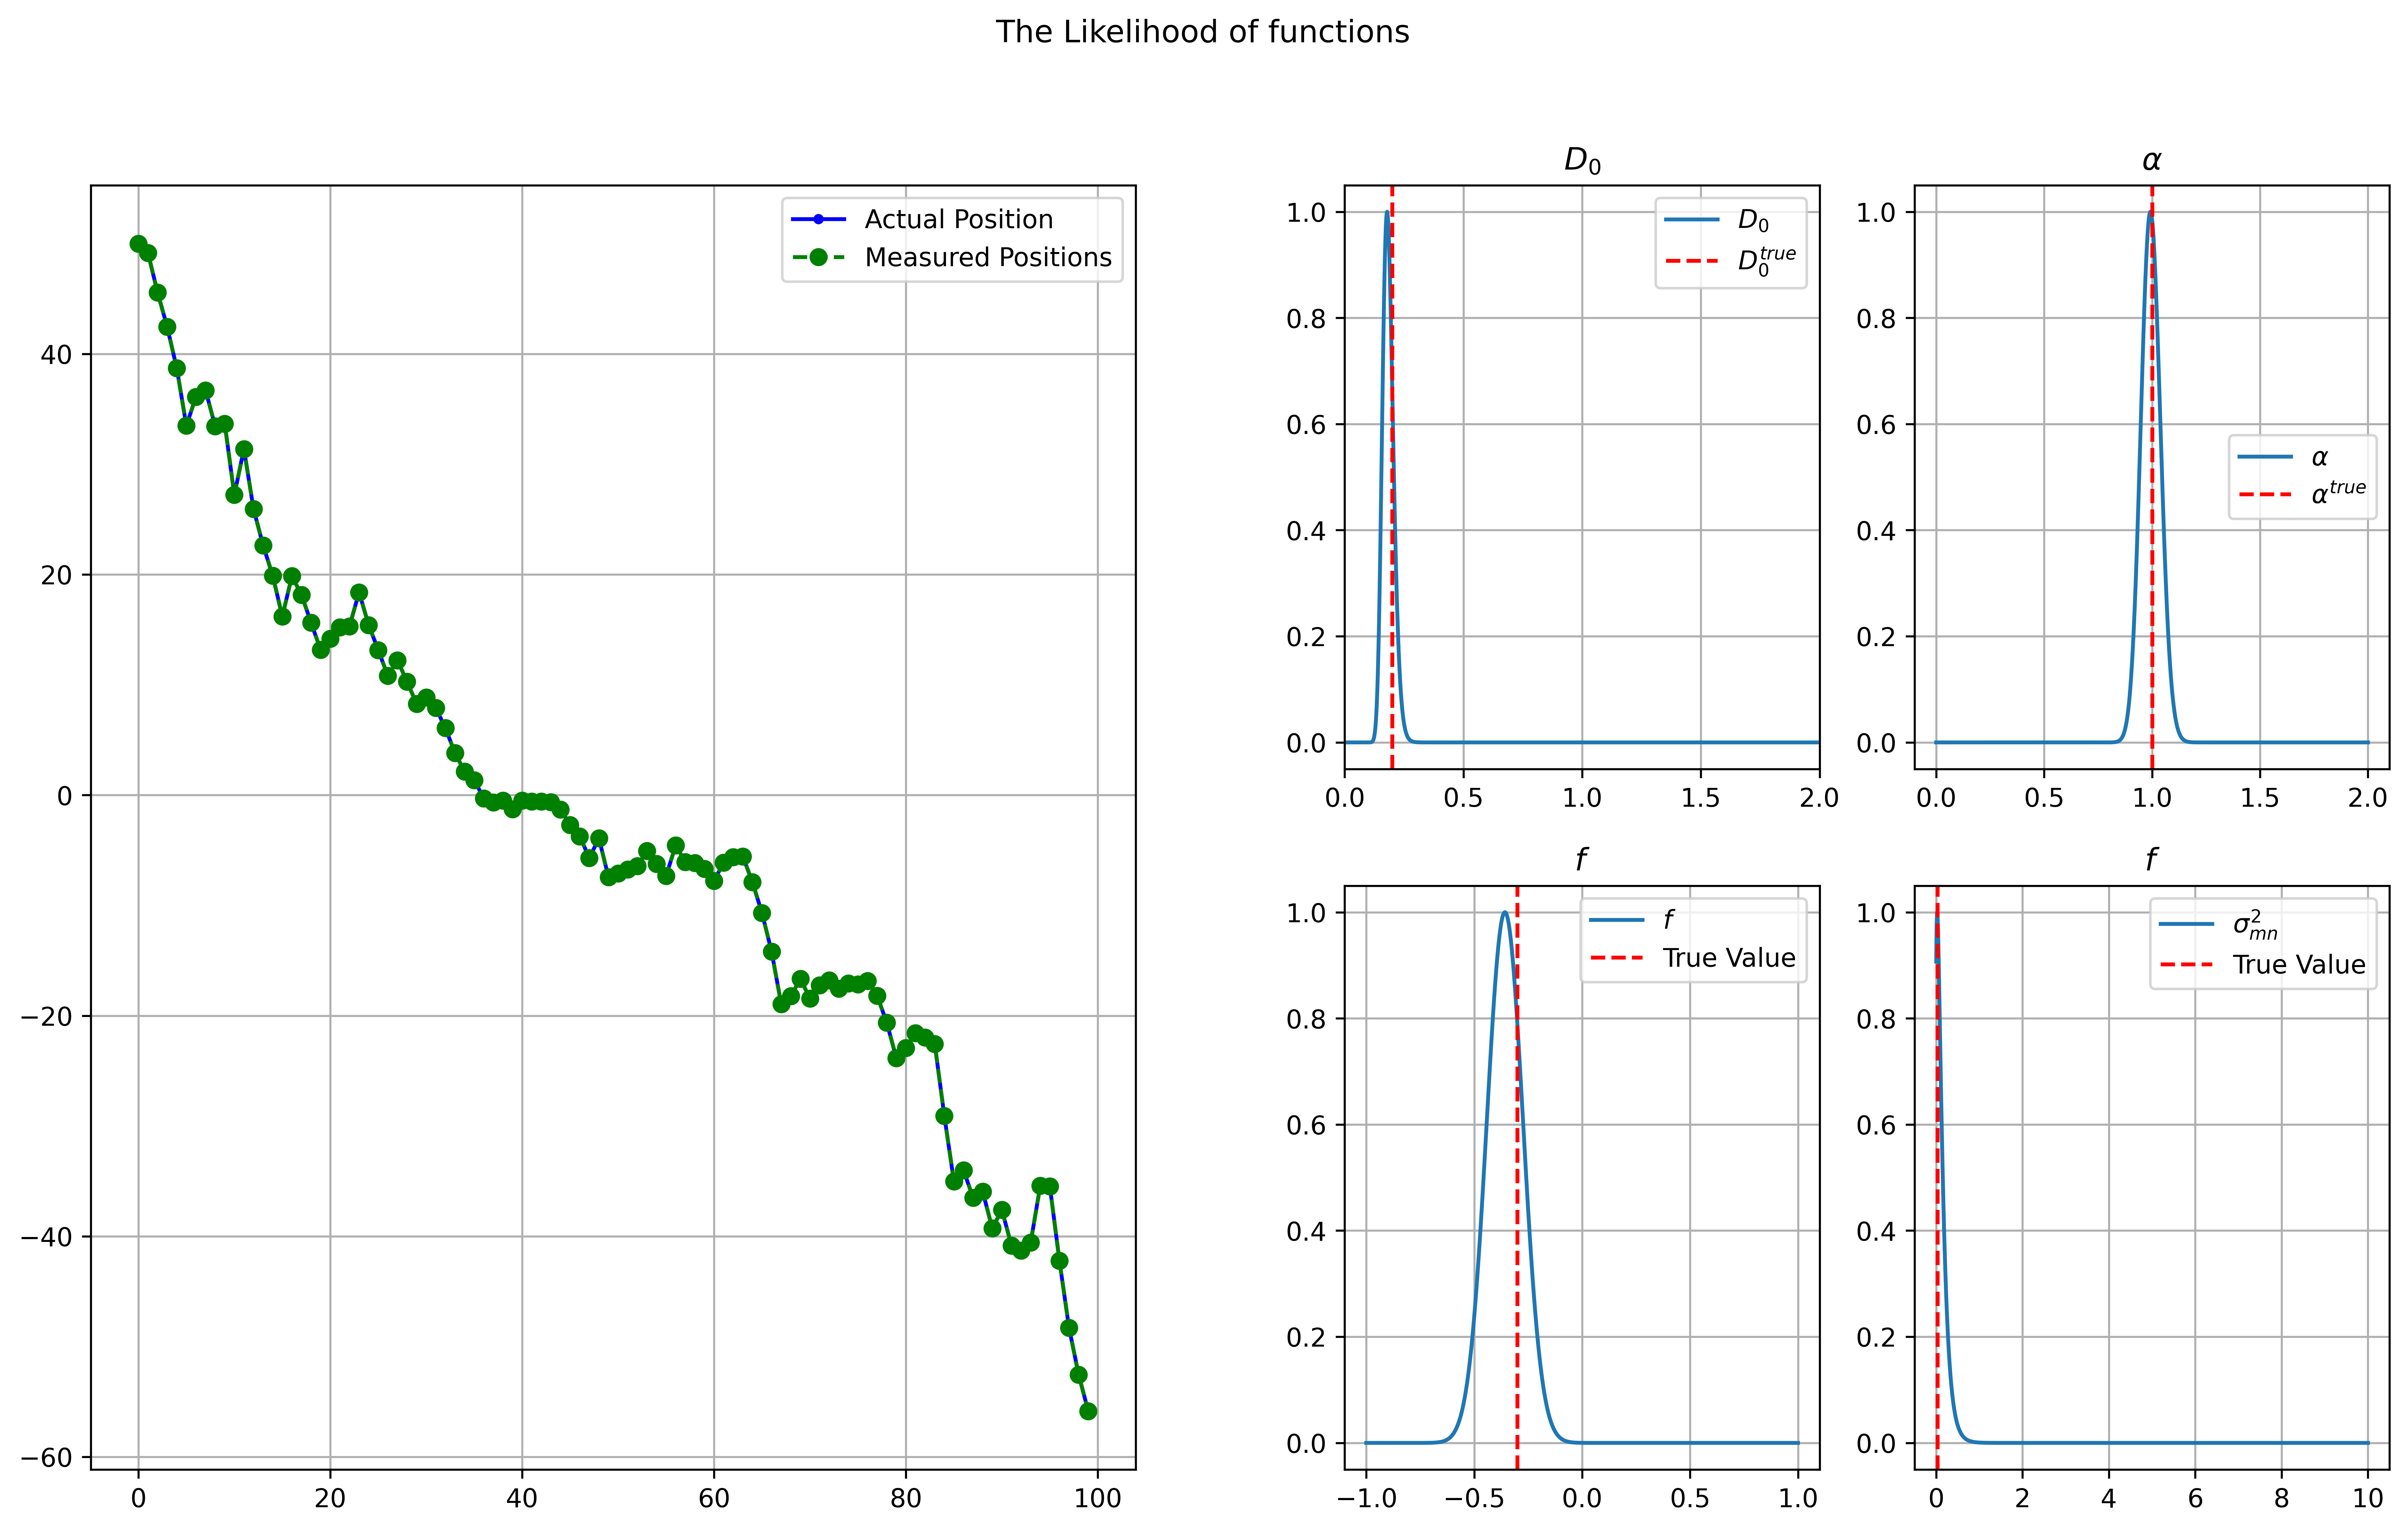

In [17]:
fig = plt.figure(figsize = (16,9), dpi = 600)

gs0 = gridspec.GridSpec(1, 2, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[:, :])

gs01 = gs0[1].subgridspec(2, 2)

ax2 = fig.add_subplot(gs01[:1, :1])
ax4 = fig.add_subplot(gs01[1, :1])

ax3 = fig.add_subplot(gs01[:1, -1])
ax5 = fig.add_subplot(gs01[-1,1 ])


# convert the loglikelihood to likelihood and normalize them
# the variable name might be confusing, ll is likelihood 
llA = np.exp(logPROBA - max(logPROBA))
llD = np.exp(logPROBD - max(logPROBD))
llF = np.exp(logPROBF - max(logPROBF))
llMN = np.exp(logPROBMN - max(logPROBMN))
# mllA = d_range[np.where(llA == 1)[0][0]]

plt.suptitle("The Likelihood of functions")

ax1.plot(t_clean_free, xtrue,'.-b',label = r"Actual Position")
ax1.plot(t_clean_free, xmeasured,'o--g',label = r"Measured Positions")
ax1.grid()
ax1.legend()

ax2.plot(d_range, llD, label = r"$D_0$")
ax2.axvline(x = D_0,ls ='--', color = 'r', label = r"$D_0^{true}$")
ax2.set_title(r"$D_0$")
ax2.set_xlim((0,2))
ax2.grid()
ax2.legend()

# axes[0][0].plot(d_range, np.exp(logPROBD1 - max(logPROBD1)), label = r"$\alpha$")

ax3.plot(alpha_range, llA, label = r"$\alpha$")
ax3.axvline(x = ALPHA_M,ls ='--', color = 'r', label = r"$\alpha^{true}$")
ax3.set_title(r"$\alpha$")
ax3.grid()
ax3.legend(loc = "right")

ax4.plot(F_L_range, llF, label = r"$f$")
ax4.axvline(x = F_L[1],ls ='--', color = 'r', label = "True Value")
ax4.set_title(r"$f$")
ax4.grid()
ax4.legend()

ax5.plot(MN_range, llMN, label = r"$\sigma^2_{mn}$")
ax5.axvline(x = varmntemp,ls ='--', color = 'r', label = "True Value")
ax5.set_title(r"$f$")
ax5.grid()
ax5.legend()

In [43]:
N = 1000
n = 100

# time step dt
DT = (t_e - t_0)/n

# log likelihood array initialization
logPROBD = np.zeros(N)
logPROBA = np.zeros(N)
logPROBF = np.zeros(N)
logPROBMN = np.zeros(N)

alpha_range = np.linspace(0, 2, N)
d_range=np.linspace(0.001,2,N)
F_L_range=np.linspace(-1,1,N)
MN_range = np.linspace(0, 10, N)

varmntemp = 0
ftemp = F_L[0]
# t_clean_free,xmeasured1, xtrue = NoisyModel(n,t_e,ftemp,D_0,ALPHA_M,varmntemp)
t_clean_free,xmeasured1 = Model(n,t_e,ftemp,D_0,ALPHA_M)



for i in range(0,N):
    # log likelihood for the applied force over a range of values    
    logPROBF[i] = noisylikelihoodcalc(xmeasured1,DT,D_0,F_L_range[i],ALPHA_M, varmntemp)

    # log likelihood for the applied force over a range of values    
    logPROBD[i] = noisylikelihoodcalc(xmeasured1,DT,d_range[i],ftemp,ALPHA_M, varmntemp)
    
    # log likelihood for the applied force over a range of values    
    logPROBA[i] = noisylikelihoodcalc(xmeasured1,DT,D_0,ftemp,alpha_range[i], varmntemp)

    # log likelihood for the applied force over a range of values    
    logPROBMN[i] = noisylikelihoodcalc(xmeasured1,DT,D_0,ftemp,ALPHA_M, MN_range[i])

In [45]:
xmeasured1

array([50.        , 53.10071127, 55.27738091, 56.81307354, 48.61059635,
       50.12018843, 46.53123838, 53.34085674, 52.63357553, 49.67459317,
       46.61841947, 50.50531675, 46.74847504, 48.91504256, 47.61180515,
       51.9014706 , 53.43320788, 50.00628398, 49.90168987, 54.16267788,
       56.80590785, 56.79827237, 54.22607794, 47.10563709, 41.12137786,
       37.59538389, 37.84325983, 41.56377564, 45.76755353, 43.26035629,
       37.70839908, 31.46893958, 34.35568262, 37.0864419 , 33.36247944,
       36.74175705, 39.6599747 , 40.00330744, 35.82468685, 31.63649341,
       28.09368401, 30.07786565, 31.72524123, 35.93238513, 34.82677544,
       38.67363349, 36.09859216, 37.09908301, 42.45240402, 45.57306933,
       36.51074303, 36.34342333, 38.30094781, 45.30292533, 44.59842508,
       40.33343335, 44.32877676, 40.76548707, 49.79276568, 54.41707482,
       48.10972128, 45.70586468, 44.94807025, 44.55837477, 47.26178949,
       50.2528731 , 47.16549902, 51.67198913, 56.40555552, 58.18

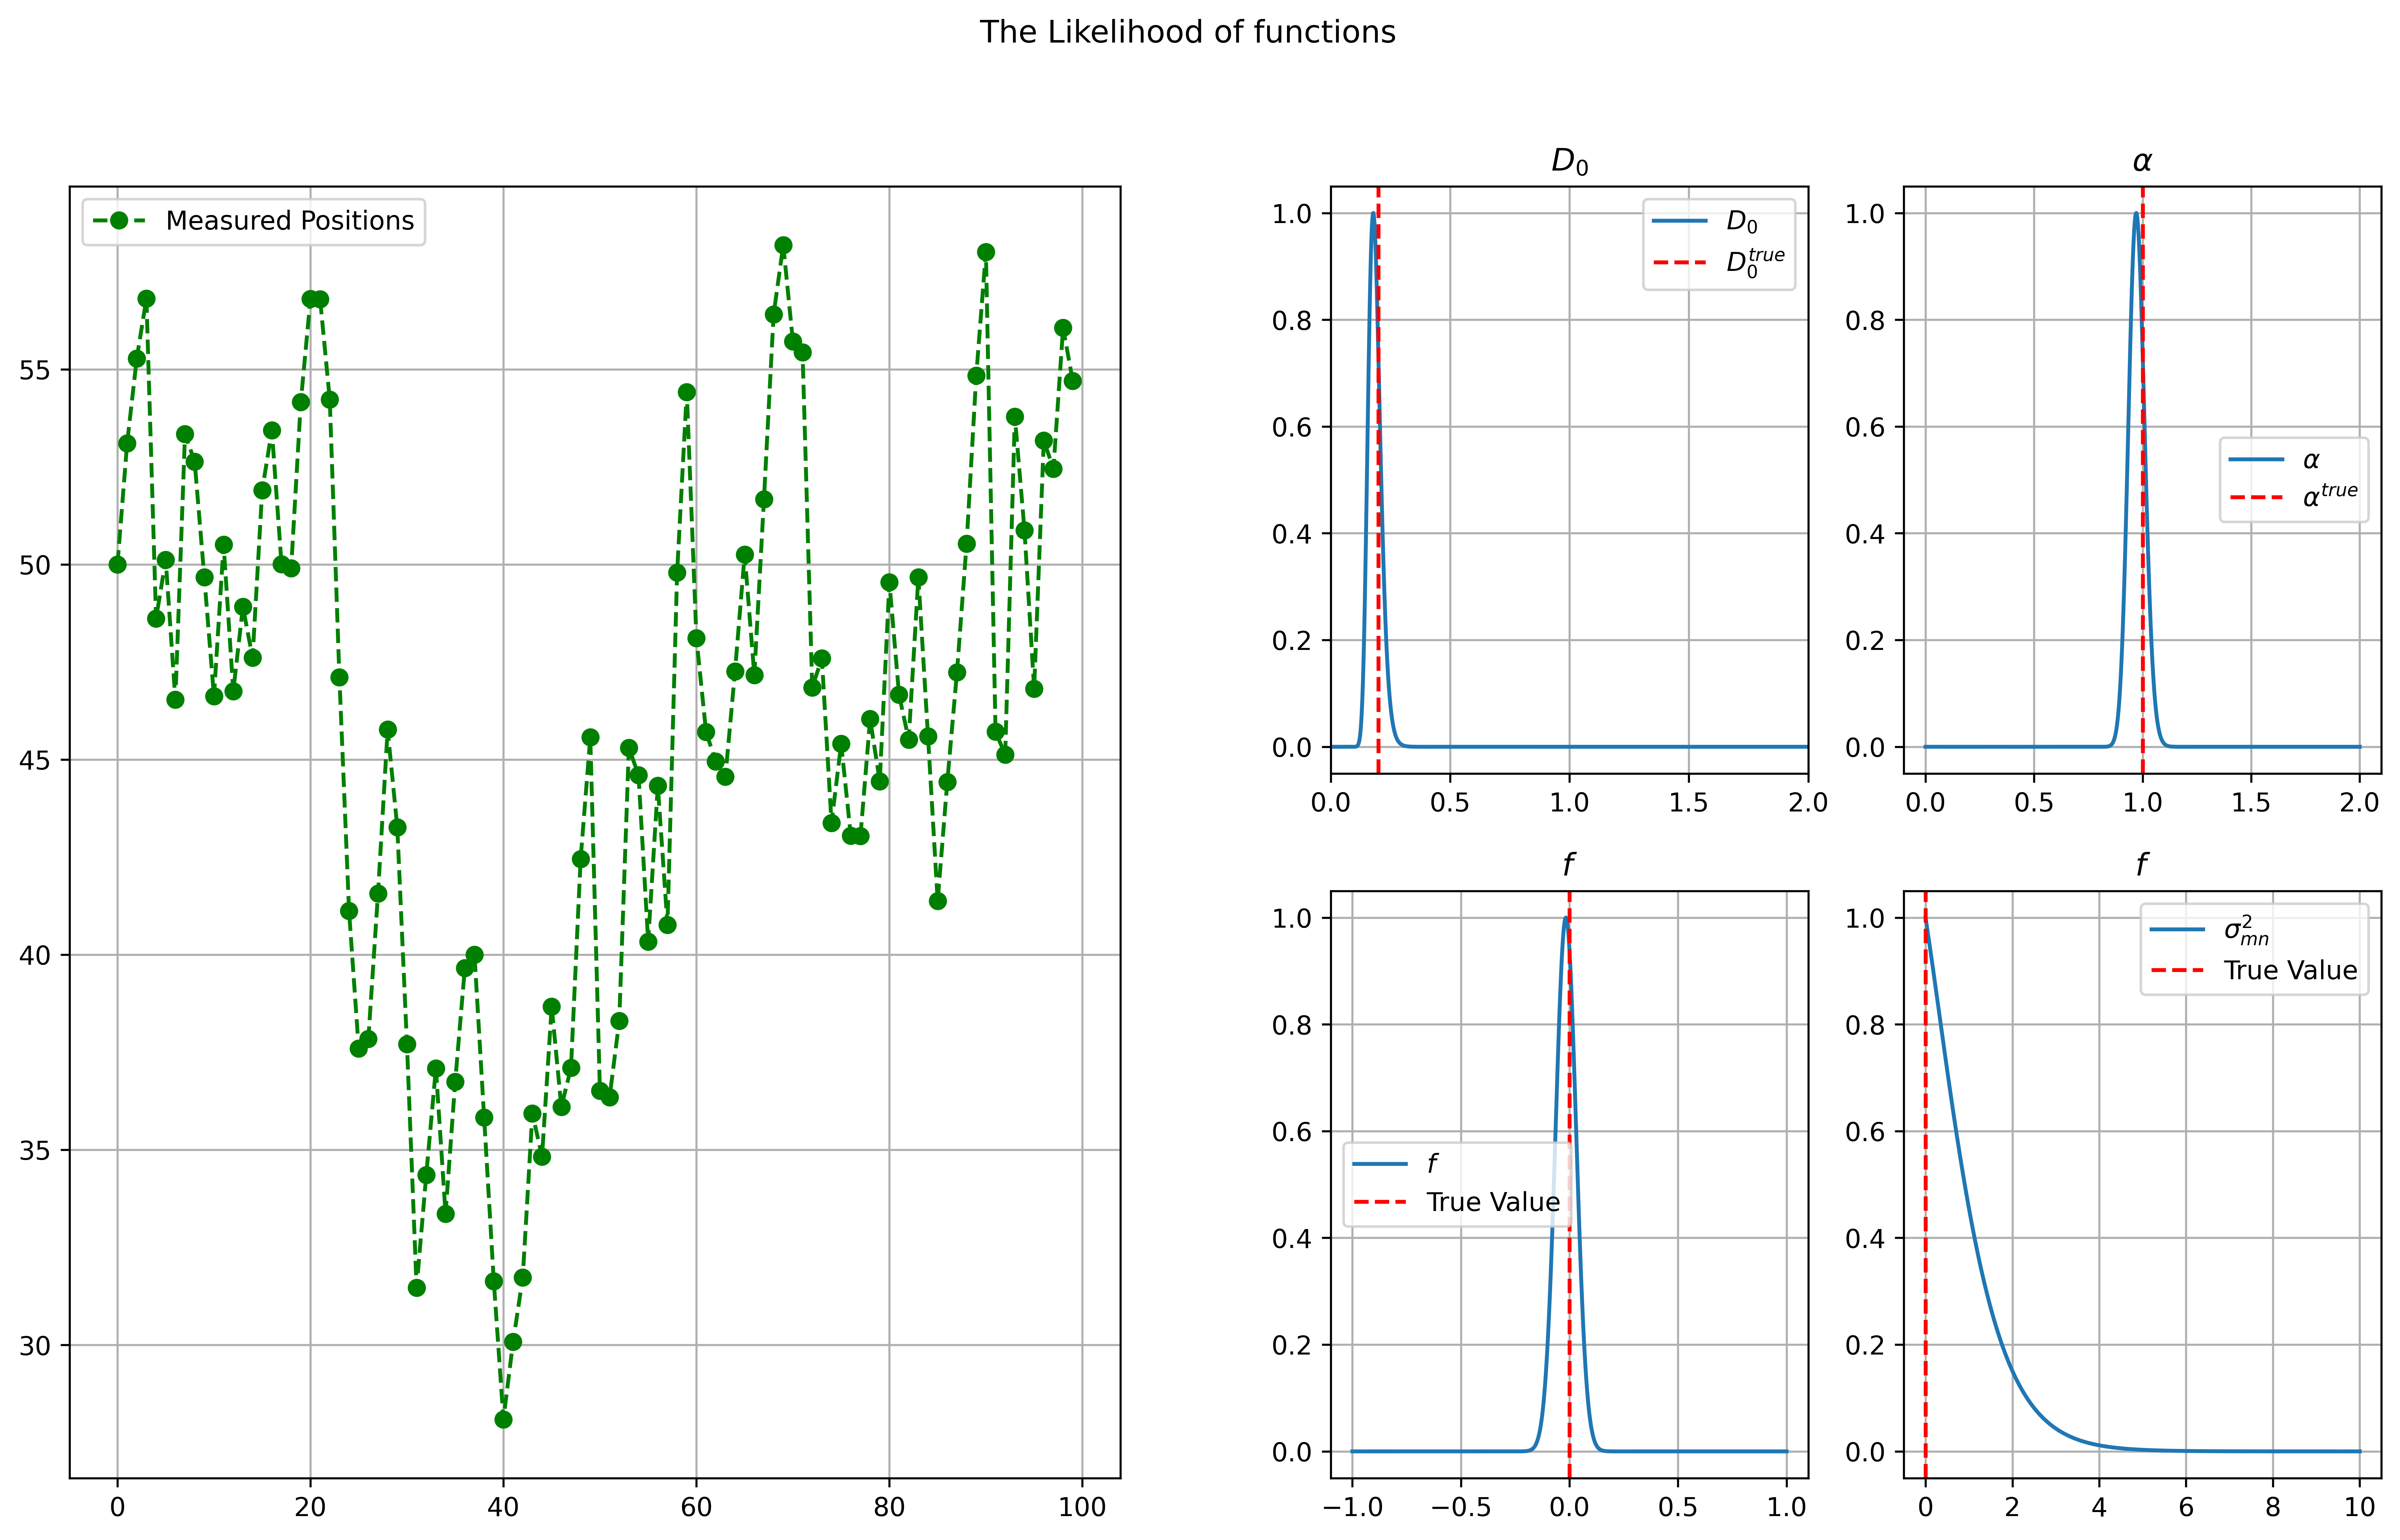

In [44]:
fig = plt.figure(figsize = (16,9), dpi = 600)

# Gridspec shit have to read later, boiler plate code from matplotlib docs
gs0 = gridspec.GridSpec(1, 2, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[:, :])
gs01 = gs0[1].subgridspec(2, 2)
ax2 = fig.add_subplot(gs01[:1, :1])
ax4 = fig.add_subplot(gs01[1, :1])
ax3 = fig.add_subplot(gs01[:1, -1])
ax5 = fig.add_subplot(gs01[-1,1 ])


# convert the loglikelihood to likelihood and normalize them
# the variable name might be confusing, ll is likelihood 
llA = np.exp(logPROBA - max(logPROBA))
llD = np.exp(logPROBD - max(logPROBD))
llF = np.exp(logPROBF - max(logPROBF))
llMN = np.exp(logPROBMN - max(logPROBMN))
# mllA = d_range[np.where(llA == 1)[0][0]]

plt.suptitle("The Likelihood of functions")

# ax1.plot(t_clean_free, xtrue,'.-b',label = r"Actual Position")
ax1.plot(t_clean_free, xmeasured1,'o--g',label = r"Measured Positions")
ax1.grid()
ax1.legend()

ax2.plot(d_range, llD, label = r"$D_0$")
ax2.axvline(x = D_0,ls ='--', color = 'r', label = r"$D_0^{true}$")
ax2.set_title(r"$D_0$")
ax2.set_xlim((0,2))
ax2.grid()
ax2.legend()

# axes[0][0].plot(d_range, np.exp(logPROBD1 - max(logPROBD1)), label = r"$\alpha$")

ax3.plot(alpha_range, llA, label = r"$\alpha$")
ax3.axvline(x = ALPHA_M,ls ='--', color = 'r', label = r"$\alpha^{true}$")
ax3.set_title(r"$\alpha$")
ax3.grid()
ax3.legend(loc = "right")

ax4.plot(F_L_range, llF, label = r"$f$")
ax4.axvline(x = ftemp,ls ='--', color = 'r', label = "True Value")
ax4.set_title(r"$f$")
ax4.grid()
ax4.legend()

ax5.plot(MN_range, llMN, label = r"$\sigma^2_{mn}$")
ax5.axvline(x = varmntemp,ls ='--', color = 'r', label = "True Value")
ax5.set_title(r"$f$")
ax5.grid()
ax5.legend()

## Observations and Likelihood Calculations under Large Measurement noise

We can see that the maximum likelihood estimates for this particular can be seen with quite a large deivation due to the apparently large amount of measurement noise.

In [21]:
N = 1000
n = 100

# time step dt
DT = (t_e - t_0)/n

# log likelihood array initialization
logPROBD = np.zeros(N)
logPROBD1 = np.zeros(N)

logPROBA = np.zeros(N)
logPROBF = np.zeros(N)
logPROBMN = np.zeros(N)

alpha_range = np.linspace(0, 2, N)
d_range=np.linspace(0.001,5,N)
F_L_range=np.linspace(-1,1,N)
MN_range = np.linspace(0, 50, N)

varmntemp = 30
ftemp = F_L[0]
t_clean_free,xmeasured, xtrue = NoisyModel(n,t_e,ftemp,D_0,ALPHA_M,varmntemp)


for i in range(0,N):
    
    logPROBF[i] = noisylikelihoodcalc(xmeasured,DT,D_0,F_L_range[i],ALPHA_M, varmntemp)

    logPROBD[i] = noisylikelihoodcalc(xmeasured,DT,d_range[i],ftemp,ALPHA_M, varmntemp)

    # logPROBD1[i] = noisylikelihoodcalc(xtrue,DT,d_range[i],F_L[1],ALPHA_M, varmntemp)


    # logPROBD1[i] = SDE_logl_m(xmeasured,[d_range[i],ALPHA_M,F_L[1],varmntemp],1)

    
    logPROBA[i] = noisylikelihoodcalc(xmeasured,DT,D_0,ftemp,alpha_range[i], varmntemp)
    
    logPROBMN[i] = noisylikelihoodcalc(xmeasured,DT,D_0,ftemp,ALPHA_M, MN_range[i])

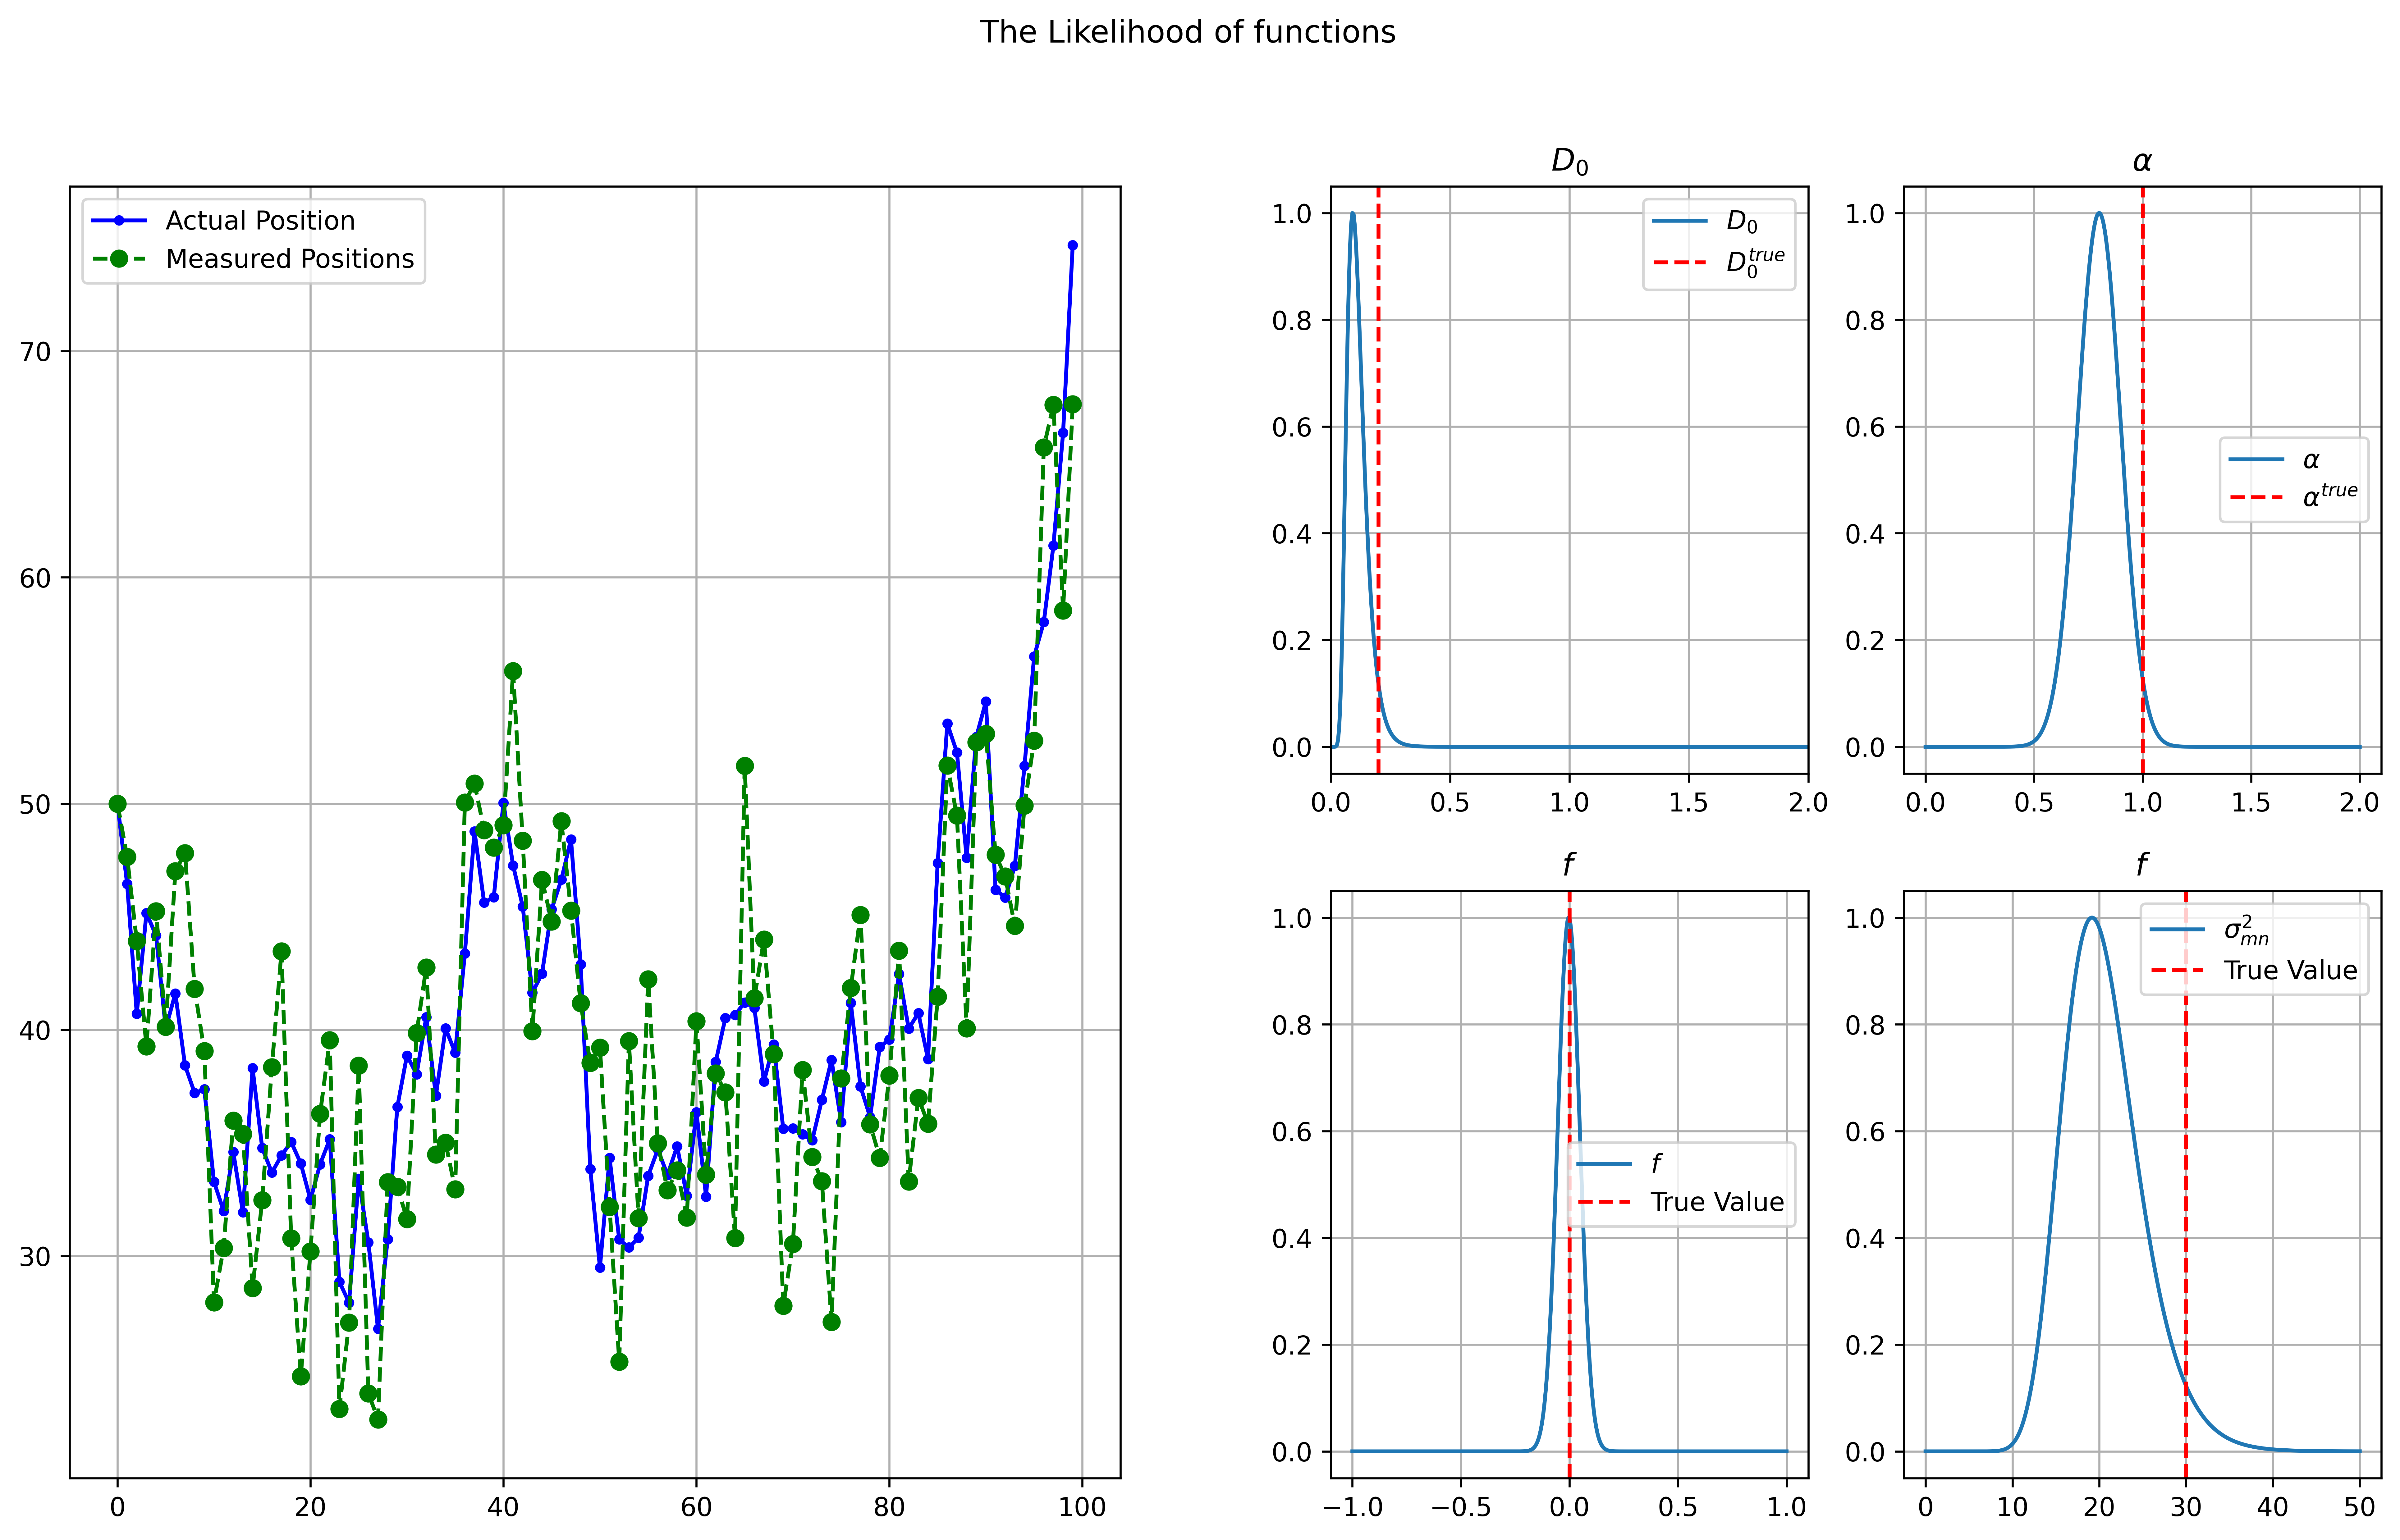

In [22]:
fig = plt.figure(figsize = (16,9), dpi = 600)

gs0 = gridspec.GridSpec(1, 2, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[:, :])

gs01 = gs0[1].subgridspec(2, 2)

ax2 = fig.add_subplot(gs01[:1, :1])
ax4 = fig.add_subplot(gs01[1, :1])

ax3 = fig.add_subplot(gs01[:1, -1])
ax5 = fig.add_subplot(gs01[-1,1 ])


# convert the loglikelihood to likelihood and normalize them
# the variable name might be confusing, ll is likelihood 
llA = np.exp(logPROBA - max(logPROBA))
llD = np.exp(logPROBD - max(logPROBD))
llF = np.exp(logPROBF - max(logPROBF))
llMN = np.exp(logPROBMN - max(logPROBMN))
# mllA = d_range[np.where(llA == 1)[0][0]]

plt.suptitle("The Likelihood of functions")

ax1.plot(t_clean_free, xtrue,'.-b',label = r"Actual Position")
ax1.plot(t_clean_free, xmeasured,'o--g',label = r"Measured Positions")
ax1.grid()
ax1.legend()

ax2.plot(d_range, llD, label = r"$D_0$")
ax2.axvline(x = D_0,ls ='--', color = 'r', label = r"$D_0^{true}$")
ax2.set_title(r"$D_0$")
ax2.set_xlim((0,2))
ax2.grid()
ax2.legend()

# axes[0][0].plot(d_range, np.exp(logPROBD1 - max(logPROBD1)), label = r"$\alpha$")

ax3.plot(alpha_range, llA, label = r"$\alpha$")
ax3.axvline(x = ALPHA_M,ls ='--', color = 'r', label = r"$\alpha^{true}$")
ax3.set_title(r"$\alpha$")
ax3.grid()
ax3.legend(loc = "right")

ax4.plot(F_L_range, llF, label = r"$f$")
ax4.axvline(x = ftemp,ls ='--', color = 'r', label = "True Value")
ax4.set_title(r"$f$")
ax4.grid()
ax4.legend()

ax5.plot(MN_range, llMN, label = r"$\sigma^2_{mn}$")
ax5.axvline(x = varmntemp,ls ='--', color = 'r', label = "True Value")
ax5.set_title(r"$f$")
ax5.grid()
ax5.legend()